# System identification of Lindblad master equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, inv, norm
from qutip import rand_herm, rand_dm, mesolve, Qobj, fidelity

from ncpol2sdpa import generate_variables, SdpRelaxation
from sympy import Matrix, I, eye, re, im, diag, solve, lambdify

from scipy.optimize import minimize

from tqdm import tqdm

# utilities

In [2]:
def unknown_complex_matrix(name, n):
    return Matrix(n, n, generate_variables('Re' + name, n * n)) \
        + I * Matrix(n, n, generate_variables('Im' + name, n * n))

In [3]:
def unknown_complex_tracless_matrix(name, n):
    result = Matrix(n, n, generate_variables('Re' + name, n * n - 1) + [0,])
    result += I * Matrix(n, n, generate_variables('Im' + name, n * n - 1) + [0,])
    
    result[-1, -1] = -result.trace()
    return result

In [4]:
def unknown_real_matrix(name, n):
    return Matrix(n, n, generate_variables(name, n * n))

In [5]:
def unknown_hermitian_matrix(name, n):
    
    x = generate_variables(name, n ** 2)
    M = diag(*x[:n])
    M /= 2
    x = x[n:]

    for i in range(n - 1):
        for j in range(i + 1, n):
            M[i, j] = x.pop() + I * x.pop()
            
    M += M.H
    
    return M

# Generate data

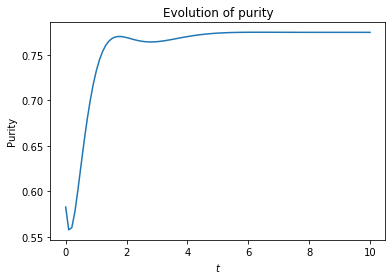

In [6]:
H_exact = rand_herm(2)
                    
A_exact = np.random.rand(2, 2) + 1j * np.random.rand(2, 2)
#A_exact[-1, -1] = 0
#A_exact[-1, -1] = -A_exact.trace()

results = mesolve(H_exact, rand_dm(2), np.linspace(0, 10, 100), [Qobj(A_exact)])
# Comvert states to numpy array
rho = [_.data.toarray() for _ in results.states]

plt.title("Evolution of purity")
plt.plot(results.times, [_.purity() for _ in results.states])
plt.xlabel('$t$')
plt.ylabel('Purity')
plt.show()

In [7]:
H_exact * A_exact - A_exact * H_exact

array([[-0.48209183+0.8242848j , -0.18136817-0.39318575j],
       [-0.80034035-0.14427959j,  0.48209183-0.8242848j ]])

# Define objective function

In [8]:
H = unknown_hermitian_matrix('H', 2)
A = unknown_complex_tracless_matrix('A', H.shape[0])

def rhs(rho):
    """
    Right hand side of the Lindblad master equation
    """
    return -I * (H @ rho - rho @ H) \
        + A @ rho @ A.H - (A.H @ A @ rho + rho @ A.H @ A) / 2

In [9]:
# the density matrix integrated over time
int_rho = np.trapz(
    rho,
    x=results.times,
    axis=0
)

In [10]:
obj = (rho[-1] - rho[0] - rhs(int_rho)).norm() ** 2
obj = re(obj.simplify())

## Check that the exact solution zeros the objective function

In [11]:
exact_solution = solve(H - H_exact) 
exact_solution.update(solve(A - A_exact))

obj.subs(exact_solution)

58.6954294239036*ImA0**4 - 103.988827493696*ImA0**3*ImA1 + 66.9293637210738*ImA0**3*ImA2 + 242.307517264129*ImA0**3*ReA1 + 155.954138018379*ImA0**3*ReA2 + 327.762960212156*ImA0**2*ImA1**2 - 336.192816391585*ImA0**2*ImA1*ImA2 - 242.307517264129*ImA0**2*ImA1*ReA0 - 10.6359627736072*ImA0**2*ImA1*ReA1 - 31.9078883208217*ImA0**2*ImA1*ReA2 + 154.30236595134*ImA0**2*ImA2**2 - 155.954138018379*ImA0**2*ImA2*ReA0 + 31.9078883208217*ImA0**2*ImA2*ReA1 + 10.6359627736072*ImA0**2*ImA2*ReA2 + 117.390858847807*ImA0**2*ReA0**2 - 103.988827493696*ImA0**2*ReA0*ReA1 + 66.9293637210738*ImA0**2*ReA0*ReA2 + 337.872281929362*ImA0**2*ReA1**2 + 396.84874669482*ImA0**2*ReA1*ReA2 + 164.411687668546*ImA0**2*ReA2**2 + 55.7884348167396*ImA0**2 - 56.6268467184257*ImA0*ImA1**3 + 38.0971148321146*ImA0*ImA1**2*ImA2 + 10.6359627736072*ImA0*ImA1**2*ReA0 + 131.947931037783*ImA0*ImA1**2*ReA1 + 88.7712414149082*ImA0*ImA1**2*ReA2 - 47.3619807752702*ImA0*ImA1*ImA2**2 - 6.30831524725202e-15*ImA0*ImA1*ImA2*ReA1 + 7.1054273576009

In [12]:
"""
level = 2

sdp = SdpRelaxation(list(obj.free_symbols))
sdp.get_relaxation(level, objective=obj)
sdp.solve(solver='mosek')

# extract the values of control
if sdp.status == 'optimal':
    solution = {var: sdp[var] for var in sdp.variables}
else:
    solution = None

obj.subs(solution)
"""

"\nlevel = 2\n\nsdp = SdpRelaxation(list(obj.free_symbols))\nsdp.get_relaxation(level, objective=obj)\nsdp.solve(solver='mosek')\n\n# extract the values of control\nif sdp.status == 'optimal':\n    solution = {var: sdp[var] for var in sdp.variables}\nelse:\n    solution = None\n\nobj.subs(solution)\n"

In [13]:
#H.subs(solution)

## using Scipy for minimization

In [14]:
# get the objective function
f = re(obj)

# list of unknowns
x = list(obj.free_symbols)

# symbolically get the Jacobian
jac = [f.diff(_) for _ in x]

f = lambdify(x, f, 'numpy')
jac = lambdify(x, jac, 'numpy')

# Use the conjugate gradient method in scipy since we have both the Jacobian and Hessian of the objective function
scipy_solution = minimize(
    lambda _: f(*_),
    np.ones(len(x)),
    jac=lambda _: np.array(jac(*_)),
)

if scipy_solution.success:
    solution = dict(zip(x, scipy_solution.x))
    
    H_reconstructed = np.array(H.subs(solution), dtype=np.complex)
    A_reconstructed = np.array(A.subs(solution), dtype=np.complex)
    
else:
    solution = H_reconstructed = A_reconstructed = None

In [15]:
A_reconstructed, A_exact

(array([[ 1.29029884+0.41177545j, -0.29615749+0.69186724j],
        [-0.41591261+0.06232886j, -1.29029884-0.41177545j]]),
 array([[0.66566918+0.02645737j, 0.75558626+0.10455882j],
        [0.78574923+0.63614056j, 0.36275197+0.78840625j]]))

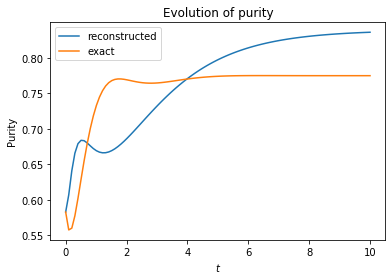

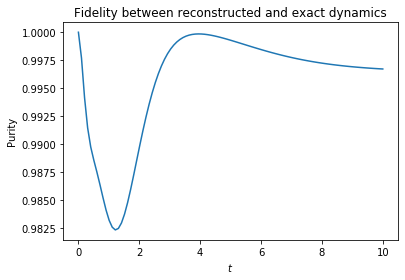

In [16]:
results_reconstructed = mesolve(
    Qobj(H_reconstructed), Qobj(rho[0]), results.times, [Qobj(A_reconstructed)]
)

plt.title("Evolution of purity")
plt.plot(
    results.times, 
    [_.purity() for _ in results_reconstructed.states],
    label='reconstructed'
)
plt.plot(
    results.times, 
    [_.purity() for _ in results.states],
    label='exact'
)

plt.xlabel('$t$')
plt.ylabel('Purity')
plt.legend()
plt.show()

plt.title("Fidelity between reconstructed and exact dynamics")
plt.plot(
    results.times, 
    [fidelity(rho1, rho2) for rho1, rho2 in zip(results_reconstructed.states, results.states)]
)

plt.xlabel('$t$')
plt.ylabel('Purity')
plt.show()

# Second cost function

In [17]:
obj = 0

for t in tqdm(range(2, len(rho) + 1)):
    # the density matrix integrated over time
    int_rho = np.trapz(
        rho[:t],
        x=results.times[:t],
        axis=0
    )
    
    obj += (rho[t - 1] - rho[0] - rhs(int_rho)).norm() ** 2

obj = re(obj.simplify())

100%|██████████| 99/99 [05:48<00:00,  3.52s/it]


## Check that the exact solution zeros the objective function

In [18]:
obj.subs(exact_solution)

1896.14417759666*ImA0**4 - 3663.23197137142*ImA0**3*ImA1 + 2417.1737758112*ImA0**3*ImA2 + 7768.59527811097*ImA0**3*ReA1 + 5106.46786127078*ImA0**3*ReA2 + 10782.2004311872*ImA0**2*ImA1**2 - 11451.6364487143*ImA0**2*ImA1*ImA2 - 7768.59527811097*ImA0**2*ImA1*ReA0 - 363.975634725416*ImA0**2*ImA1*ReA1 - 1091.92690417625*ImA0**2*ImA1*ReA2 + 5260.9534857844*ImA0**2*ImA2**2 - 5106.46786127078*ImA0**2*ImA2*ReA0 + 1091.92690417625*ImA0**2*ImA2*ReA1 + 363.975634725416*ImA0**2*ImA2*ReA2 + 3792.28835519332*ImA0**2*ReA0**2 - 3663.23197137142*ImA0**2*ReA0*ReA1 + 2417.1737758112*ImA0**2*ReA0*ReA2 + 11082.8755845016*ImA0**2*ReA1**2 + 13255.6873686006*ImA0**2*ReA1*ReA2 + 5561.62863909878*ImA0**2*ReA2**2 + 1890.69707207486*ImA0**2 - 1987.37326013074*ImA0*ImA1**3 + 1364.34416235063*ImA0*ImA1**2*ImA2 + 363.975634725416*ImA0*ImA1**2*ReA0 + 4217.06356616051*ImA0*ImA1**2*ReA1 + 2885.99985774041*ImA0*ImA1**2*ReA2 - 1675.85871124068*ImA0*ImA1*ImA2**2 - 8.44591798300282e-16*ImA0*ImA1*ImA2*ReA0 - 6.64483089742887

In [19]:
"""
level = 2

sdp = SdpRelaxation(list(obj.free_symbols))
sdp.get_relaxation(level, objective=obj)
sdp.solve(solver='mosek')

# extract the values of control
if sdp.status == 'optimal':
    solution = {var: sdp[var] for var in sdp.variables}
else:
    solution = None

obj.subs(solution)
"""

"\nlevel = 2\n\nsdp = SdpRelaxation(list(obj.free_symbols))\nsdp.get_relaxation(level, objective=obj)\nsdp.solve(solver='mosek')\n\n# extract the values of control\nif sdp.status == 'optimal':\n    solution = {var: sdp[var] for var in sdp.variables}\nelse:\n    solution = None\n\nobj.subs(solution)\n"

In [20]:
#H.subs(solution)

# using Scipy for minimization

In [21]:
# get the objective function
f = re(obj)

# list of unknowns
x = list(obj.free_symbols)

# symbolically get the Jacobian
jac = [f.diff(_) for _ in x]

f = lambdify(x, f, 'numpy')
jac = lambdify(x, jac, 'numpy')

# Use the conjugate gradient method in scipy since we have both the Jacobian and Hessian of the objective function
scipy_solution = minimize(
    lambda _: f(*_),
    np.ones(len(x)),
    jac=lambda _: np.array(jac(*_)),
)

if scipy_solution.success:
    solution = dict(zip(x, scipy_solution.x))
    
    H_reconstructed = np.array(H.subs(solution), dtype=np.complex)
    A_reconstructed = np.array(A.subs(solution), dtype=np.complex)
    
else:
    solution = H_reconstructed = A_reconstructed = None

In [22]:
A_reconstructed, A_exact

(array([[ 0.40171144+0.07548816j,  0.03651289+0.76009547j],
        [-0.47702761+0.89201154j, -0.40171144-0.07548816j]]),
 array([[0.66566918+0.02645737j, 0.75558626+0.10455882j],
        [0.78574923+0.63614056j, 0.36275197+0.78840625j]]))

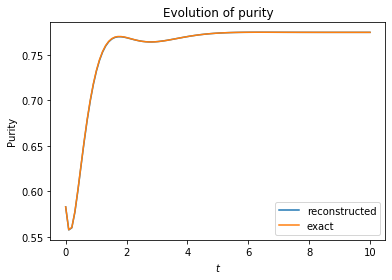

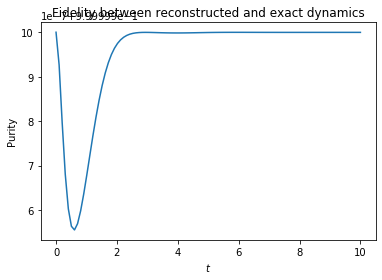

In [23]:
results_reconstructed = mesolve(
    Qobj(H_reconstructed), Qobj(rho[0]), results.times, [Qobj(A_reconstructed)]
)

plt.title("Evolution of purity")
plt.plot(
    results.times, 
    [_.purity() for _ in results_reconstructed.states],
    label='reconstructed'
)
plt.plot(
    results.times, 
    [_.purity() for _ in results.states],
    label='exact'
)

plt.xlabel('$t$')
plt.ylabel('Purity')
plt.legend()
plt.show()

plt.title("Fidelity between reconstructed and exact dynamics")
plt.plot(
    results.times, 
    [fidelity(rho1, rho2) for rho1, rho2 in zip(results_reconstructed.states, results.states)]
)

plt.xlabel('$t$')
plt.ylabel('Purity')
plt.show()

# Objective function inspired by implicit Euler method

In [24]:
dt = results.times[1] - results.times[0]

obj = 0

for t in tqdm(range(1, len(rho))):
    
    obj += (rho[t] - rho[t - 1] - dt * rhs(rho[t])).norm() ** 2

obj = re(obj.simplify())

100%|██████████| 99/99 [06:04<00:00,  3.68s/it]


## Check that the exact solution zeros the objective function

In [25]:
obj.subs(exact_solution)

0.615043187375312*ImA0**4 - 1.05512779645602*ImA0**3*ImA1 + 0.678863839011446*ImA0**3*ImA2 + 2.48023584195046*ImA0**3*ReA1 + 1.56449112711894*ImA0**3*ReA2 + 3.34505581566832*ImA0**2*ImA1**2 - 3.36232645973764*ImA0**2*ImA1*ImA2 - 2.48023584195046*ImA0**2*ImA1*ReA0 - 0.107050850018386*ImA0**2*ImA1*ReA1 - 0.321152550055157*ImA0**2*ImA1*ReA2 + 1.57488783742842*ImA0**2*ImA2**2 - 1.56449112711894*ImA0**2*ImA2*ReA0 + 0.321152550055157*ImA0**2*ImA2*ReA1 + 0.107050850018386*ImA0**2*ImA2*ReA2 + 1.23008637475062*ImA0**2*ReA0**2 - 1.05512779645602*ImA0**2*ReA0*ReA1 + 0.678863839011446*ImA0**2*ReA0*ReA2 + 3.44845110450557*ImA0**2*ReA1**2 + 3.98269819276117*ImA0**2*ReA1*ReA2 + 1.67828312626567*ImA0**2*ReA2**2 + 0.554835728912059*ImA0**2 - 0.574596892908583*ImA0*ImA1**3 + 0.386464914186295*ImA0*ImA1**2*ImA2 + 0.107050850018386*ImA0*ImA1**2*ReA0 + 1.35458601032917*ImA0*ImA1**2*ReA1 + 0.896713652913411*ImA0*ImA1**2*ReA2 - 0.480530903547439*ImA0*ImA1*ImA2**2 + 1.1384122811097e-18*ImA0*ImA1*ImA2*ReA0 + 1

In [26]:
"""
level = 4

sdp = SdpRelaxation(list(obj.free_symbols))
sdp.get_relaxation(level, objective=obj)
sdp.solve(solver='mosek')

# extract the values of control
if sdp.status == 'optimal':
    solution = {var: sdp[var] for var in sdp.variables}
else:
    solution = None
    
obj.subs(solution)
"""

"\nlevel = 4\n\nsdp = SdpRelaxation(list(obj.free_symbols))\nsdp.get_relaxation(level, objective=obj)\nsdp.solve(solver='mosek')\n\n# extract the values of control\nif sdp.status == 'optimal':\n    solution = {var: sdp[var] for var in sdp.variables}\nelse:\n    solution = None\n    \nobj.subs(solution)\n"

## using Scipy for minimization

In [33]:
# get the objective function
f = re(obj)

# list of unknowns
x = list(obj.free_symbols)

# symbolically get the Jacobian
jac = [f.diff(_) for _ in x]

f = lambdify(x, f, 'numpy')
jac = lambdify(x, jac, 'numpy')

# Use the conjugate gradient method in scipy since we have both the Jacobian and Hessian of the objective function
scipy_solution = minimize(
    lambda _: f(*_),
    np.ones(len(x)),
    jac=lambda _: np.array(jac(*_)),
)

if scipy_solution.success:
    solution = dict(zip(x, scipy_solution.x))
    
    H_reconstructed = np.array(H.subs(solution), dtype=np.complex)
    A_reconstructed = np.array(A.subs(solution), dtype=np.complex)
    
else:
    solution = H_reconstructed = A_reconstructed = None

In [34]:
A_reconstructed, A_exact

(array([[ 0.44353774-7.01934549e-04j,  0.22556719+7.80897137e-01j],
        [-0.26511825+9.90418653e-01j, -0.44353774+7.01934549e-04j]]),
 array([[0.66566918+0.02645737j, 0.75558626+0.10455882j],
        [0.78574923+0.63614056j, 0.36275197+0.78840625j]]))

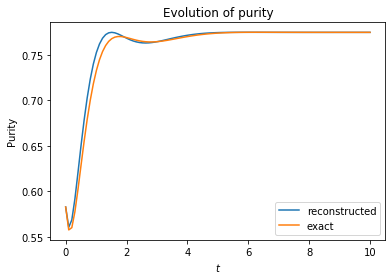

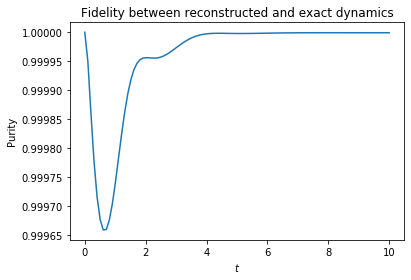

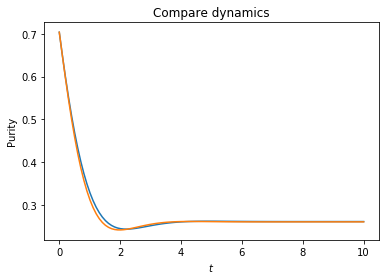

In [35]:
results_reconstructed = mesolve(
    Qobj(H_reconstructed), Qobj(rho[0]), results.times, [Qobj(A_reconstructed)]
)

plt.title("Evolution of purity")
plt.plot(
    results.times, 
    [_.purity() for _ in results_reconstructed.states],
    label='reconstructed'
)
plt.plot(
    results.times, 
    [_.purity() for _ in results.states],
    label='exact'
)

plt.xlabel('$t$')
plt.ylabel('Purity')
plt.legend()
plt.show()

plt.title("Fidelity between reconstructed and exact dynamics")
plt.plot(
    results.times, 
    [fidelity(rho1, rho2) for rho1, rho2 in zip(results_reconstructed.states, results.states)]
)

plt.xlabel('$t$')
plt.ylabel('Purity')
plt.show()

plt.title("Compare dynamics")
plt.plot(
    results.times, 
    [rho[0,0].real for rho in results.states],
    label=r'exact $\langle 0|\rho|0 \rangle$'
)

plt.plot(
    results.times, 
    [rho[0,0].real for rho in results_reconstructed.states],
    label=r'reconstructed $\langle 0|\rho|0 \rangle$'
)

plt.xlabel('$t$')
plt.ylabel('Purity')
plt.show()